<a href="https://colab.research.google.com/github/sanjana-ghanta/CS5805FinalProject/blob/main/color_palette_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
!pip install -q opencv-python scikit-learn matplotlib pandas

In [62]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [63]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
DATA_ROOT = "/content/drive/MyDrive/ML_Color_Project"
print(os.listdir(DATA_ROOT))

['warm', 'cool', 'neutral', 'color_palette_project.ipynb']


Loading image paths

In [65]:
import glob

def load_image_paths(data_root):
    classes = ["warm", "neutral", "cool"]
    paths_labels = []

    for cls in classes:
        cls_dir = os.path.join(data_root, cls)
        if not os.path.isdir(cls_dir):
            print(f"Warning: directory not found: {cls_dir}")
            continue

        for ext in ("*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"):
            for p in glob.glob(os.path.join(cls_dir, ext)):
                paths_labels.append((p, cls))

    return paths_labels

paths_labels = load_image_paths(DATA_ROOT)
print(f"Found {len(paths_labels)} images total.")
paths_labels[:5]


Found 143 images total.


[('/content/drive/MyDrive/ML_Color_Project/warm/warm1.jpg', 'warm'),
 ('/content/drive/MyDrive/ML_Color_Project/warm/warm2.jpg', 'warm'),
 ('/content/drive/MyDrive/ML_Color_Project/warm/warm3.jpg', 'warm'),
 ('/content/drive/MyDrive/ML_Color_Project/warm/warm4.jpg', 'warm'),
 ('/content/drive/MyDrive/ML_Color_Project/warm/warm6.jpg', 'warm')]

In [66]:
# Load OpenCV's built-in frontal-face detector (Haar cascade)
face_cascade = cv2.CascadeClassifier(
    cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
)

def detect_and_crop_face(img_bgr, scaleFactor=1.1, minNeighbors=5):
    """
    Detects the largest face and returns a cropped RGB image of the face.
    Returns None if no face is found.
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(
        gray, scaleFactor=scaleFactor, minNeighbors=minNeighbors
    )

    if len(faces) == 0:
        return None

    # Take the largest detected face
    x, y, w, h = max(faces, key=lambda f: f[2] * f[3])
    face_bgr = img_bgr[y:y+h, x:x+w]
    face_rgb = cv2.cvtColor(face_bgr, cv2.COLOR_BGR2RGB)
    return face_rgb

In [67]:
def compute_ita(face_rgb):
    """
    Computes ITA for a cropped face in RGB.
    Returns ITA angle in degrees.
    """
    lab = cv2.cvtColor(face_rgb, cv2.COLOR_RGB2LAB)
    L, A, B = cv2.split(lab)

    L_mean = np.mean(L)
    B_mean = np.mean(B)

    ita = np.degrees(np.arctan((L_mean - 50) / B_mean))
    return ita


Testing on: /content/drive/MyDrive/ML_Color_Project/warm/warm1.jpg | Label: warm
Face detected! Shape: (365, 365, 3)


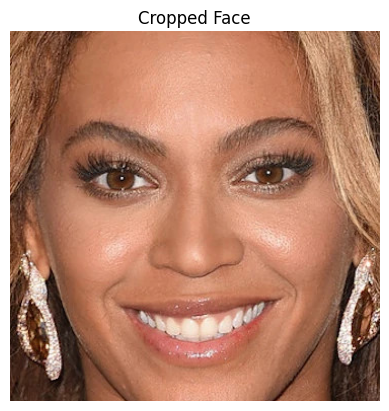

ITA for this face: 30.3632990002564


In [68]:
# Just pick the first image path from our list
test_path, test_label = paths_labels[0]
print("Testing on:", test_path, "| Label:", test_label)

img_bgr = cv2.imread(test_path)
face_rgb = detect_and_crop_face(img_bgr)

if face_rgb is None:
    print("No face detected 😭")
else:
    print("Face detected! Shape:", face_rgb.shape)
    plt.imshow(face_rgb)
    plt.axis("off")
    plt.title("Cropped Face")
    plt.show()

    ita_value = compute_ita(face_rgb)
    print("ITA for this face:", ita_value)


In [69]:
import math

def extract_features_for_image(img_path, label):
    img = cv2.imread(img_path)
    if img is None:
        print("Image failed:", img_path)
        return None

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
    faces = face_detector.detectMultiScale(gray, 1.1, 4)

    if len(faces) == 0:
        print("No face:", img_path)
        return None

    x, y, w, h = faces[0]
    face = img[y:y+h, x:x+w]

    # Mean RGB
    mean_R = face[:, :, 0].mean()
    mean_G = face[:, :, 1].mean()
    mean_B = face[:, :, 2].mean()

    # Convert to HSV and extract mean H,S,V
    hsv = cv2.cvtColor(face, cv2.COLOR_RGB2HSV)
    mean_H = hsv[:, :, 0].mean()
    mean_S = hsv[:, :, 1].mean()
    mean_V = hsv[:, :, 2].mean()

    # Convert to YCbCr and extract mean Cb, Cr
    ycbcr = cv2.cvtColor(face, cv2.COLOR_RGB2YCrCb)
    mean_Y = ycbcr[:, :, 0].mean()
    mean_Cb = ycbcr[:, :, 1].mean()
    mean_Cr = ycbcr[:, :, 2].mean()

    # Compute ITA
    bgr_face = cv2.cvtColor(face, cv2.COLOR_RGB2LAB)
    L = bgr_face[:, :, 0].mean()
    b = bgr_face[:, :, 2].mean()
    ITA = math.degrees(math.atan((L - 50) / b))

    return {
        "path": img_path,
        "label": label,
        "ITA": ITA,
        "mean_R": mean_R,
        "mean_G": mean_G,
        "mean_B": mean_B,
        "mean_H": mean_H,
        "mean_S": mean_S,
        "mean_V": mean_V,
        "mean_Y": mean_Y,
        "mean_Cb": mean_Cb,
        "mean_Cr": mean_Cr
    }

In [70]:
rows = []
for p, lbl in paths_labels:
    feats = extract_features_for_image(p, lbl)
    if feats is not None:
        rows.append(feats)

df = pd.DataFrame(rows)
display(df)
print("Shape:", df.shape)
print(df["label"].value_counts())

,path,label,ITA,mean_R,mean_G,mean_B,mean_H,mean_S,mean_V,mean_Y,mean_Cb,mean_Cr
0,/content/drive/MyDrive/ML_Color_Project/warm/w...,warm,30.363299,172.788959,117.667645,93.086515,9.610276,122.392419,172.789619,131.370036,157.576393,106.406388
1,/content/drive/MyDrive/ML_Color_Project/warm/w...,warm,6.824788,87.277367,56.057692,40.250740,11.063609,154.121672,87.280695,63.596524,144.915311,114.822485
2,/content/drive/MyDrive/ML_Color_Project/warm/w...,warm,20.262355,135.647722,89.306727,65.497176,18.846479,123.719728,135.670753,100.468962,153.142419,108.291900
3,/content/drive/MyDrive/ML_Color_Project/warm/w...,warm,30.173487,175.068594,120.551402,90.269320,10.924428,134.553634,175.073340,133.410031,157.752992,103.641657
4,/content/drive/MyDrive/ML_Color_Project/warm/w...,warm,20.093379,131.761904,87.941904,68.914402,18.908918,111.475942,131.775786,98.903434,151.484922,111.109438
...,...,...,...,...,...,...,...,...,...,...,...,...
138,/content/drive/MyDrive/ML_Color_Project/cool/c...,cool,40.747636,194.885030,159.661366,141.364409,18.288314,77.597978,195.117823,168.115404,147.122900,112.900518
139,/content/drive/MyDrive/ML_Color_Project/cool/c...,cool,37.243278,174.891858,140.178658,131.161510,19.891503,66.415281,177.001254,149.532681,146.107243,117.624840
140,/content/drive/MyDrive/ML_Color_Project/cool/c...,cool,43.760380,194.758629,169.257972,160.419113,19.895643,53.336106,195.444022,175.873264,141.493454,119.228650
141,/content/drive/MyDrive/ML_Color_Project/cool/c...,cool,27.862894,137.439663,113.206727,102.454143,18.856233,68.866667,137.657145,119.244758,141.015795,118.548857


Shape: (143, 12)
label
warm       61
cool       45
neutral    37
Name: count, dtype: int64


Train/Test Split

In [71]:
feature_cols = [
    "ITA",
    "mean_R", "mean_G", "mean_B",
    "mean_H", "mean_S", "mean_V",
    "mean_Y", "mean_Cb", "mean_Cr"
]

X = df[feature_cols].values
y = df["label"].values

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (143, 10)
y shape: (143,)


In [72]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.33,      # ~1/3 test set
    random_state=42,
    stratify=y           # keeps class balance
)

print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])
print("Train label distribution:", pd.Series(y_train).value_counts().to_dict())
print("Test label distribution:", pd.Series(y_test).value_counts().to_dict())

Train size: 95
Test size: 48
Train label distribution: {'warm': 40, 'cool': 30, 'neutral': 25}
Test label distribution: {'warm': 21, 'cool': 15, 'neutral': 12}


In [73]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [50, 100, 200],
    "max_depth": [None, 3, 5, 10],
    "min_samples_split": [2, 4],
    "min_samples_leaf": [1, 2]
}

rf = RandomForestClassifier(random_state=42)

grid = GridSearchCV(
    rf,
    param_grid,
    cv=3,
    scoring="f1_macro"
)

grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV Macro F1:", grid.best_score_)

best_clf = grid.best_estimator_
y_pred = best_clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
macro_f1 = f1_score(y_test, y_pred, average="macro")

print("TUNED Test Accuracy:", acc)
print("TUNED Macro F1:", macro_f1)

Best params: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best CV Macro F1: 0.8135271161586951
TUNED Test Accuracy: 0.875
TUNED Macro F1: 0.8598359734861251


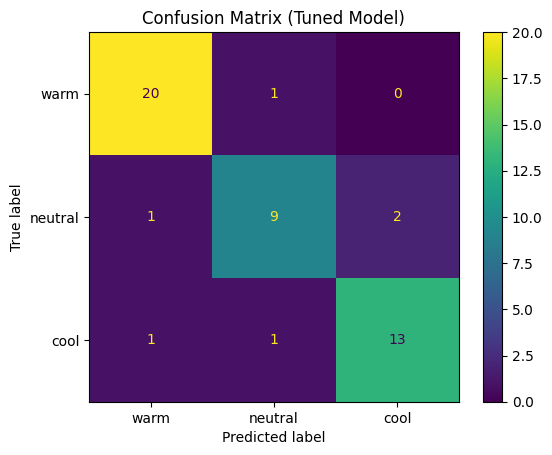

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred, labels=["warm", "neutral", "cool"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["warm", "neutral", "cool"])
disp.plot()
plt.title("Confusion Matrix (Tuned Model)")
plt.show()

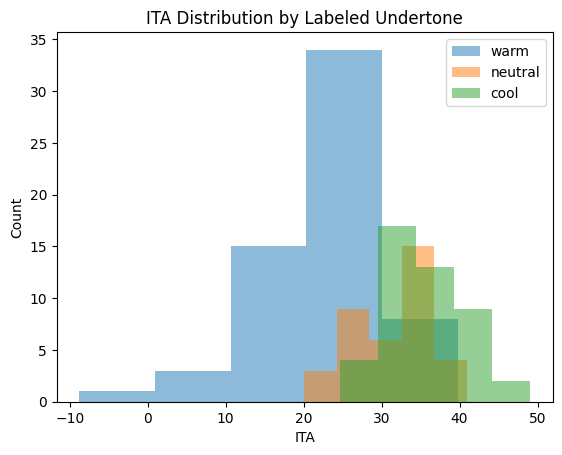

In [75]:
plt.figure()
for tone in ["warm", "neutral", "cool"]:
    subset = df[df["label"] == tone]
    plt.hist(subset["ITA"], bins=5, alpha=0.5, label=tone)

plt.xlabel("ITA")
plt.ylabel("Count")
plt.title("ITA Distribution by Labeled Undertone")
plt.legend()
plt.show()

In [76]:
PALETTES = {
    "warm": ["#FFB347", "#FF7F50", "#D2691E", "#FFD700"],
    "neutral": ["#F5F5DC", "#C0C0C0", "#B0C4DE", "#BC8F8F"],
    "cool": ["#6495ED", "#6A5ACD", "#00CED1", "#C71585"]
}

def recommend_palette(tone):
    return PALETTES.get(tone, [])

In [77]:
def tone_ita_to_season(tone, ita, light_thresh=30):
    """
    Map undertone + ITA to one of: 'Spring', 'Summer', 'Autumn', 'Winter'.
    light_thresh: ITA above this is treated as lighter/brighter.
    """
    if tone == "warm":
        return "Spring" if ita >= light_thresh else "Autumn"
    elif tone == "cool":
        return "Summer" if ita >= light_thresh else "Winter"
    else:  # neutral
        # neutrals: higher ITA -> Summer-ish, lower -> Autumn-ish
        return "Summer" if ita >= light_thresh else "Autumn"


In [78]:
SEASON_TIPS = {
    "Spring": "Light warm colors: peach, coral, warm pinks, rose gold, soft mint.",
    "Summer": "Soft cool hues: lavender, dusty blue, cool pinks, light silver.",
    "Autumn": "Rich warm tones: olive, mustard, terracotta, camel, antique gold.",
    "Winter": "Bold cool shades: emerald, royal blue, true red, black, bright white."
}

True undertone label: warm
Predicted undertone: warm
ITA: 30.36
Recommended season: Spring
Style tips: Light warm colors: peach, coral, warm pinks, rose gold, soft mint.


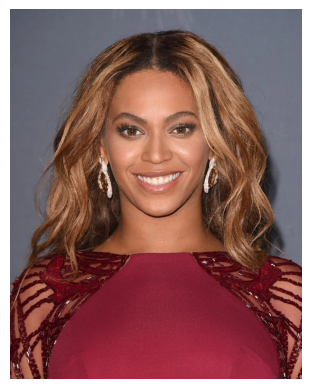

True undertone label: warm
Predicted undertone: warm
ITA: 6.82
Recommended season: Autumn
Style tips: Rich warm tones: olive, mustard, terracotta, camel, antique gold.


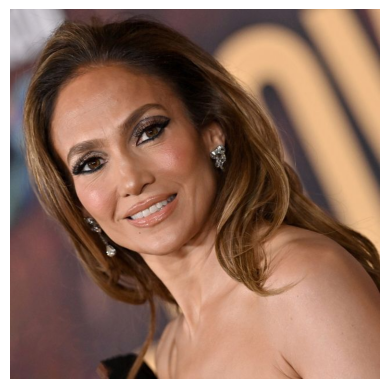

True undertone label: warm
Predicted undertone: warm
ITA: 20.26
Recommended season: Autumn
Style tips: Rich warm tones: olive, mustard, terracotta, camel, antique gold.


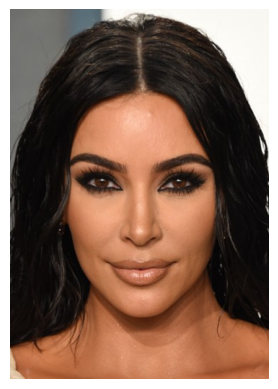

True undertone label: warm
Predicted undertone: warm
ITA: 30.17
Recommended season: Spring
Style tips: Light warm colors: peach, coral, warm pinks, rose gold, soft mint.


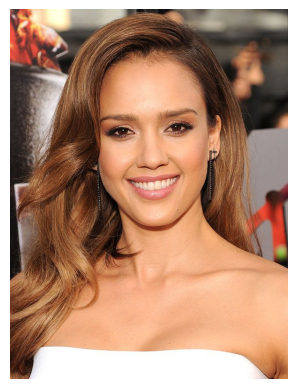

True undertone label: warm
Predicted undertone: warm
ITA: 20.09
Recommended season: Autumn
Style tips: Rich warm tones: olive, mustard, terracotta, camel, antique gold.


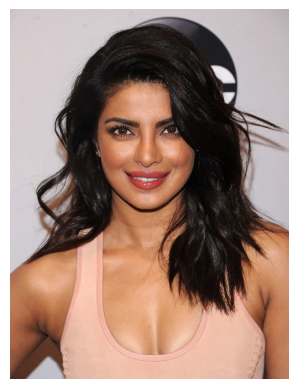

True undertone label: warm
Predicted undertone: warm
ITA: 26.44
Recommended season: Autumn
Style tips: Rich warm tones: olive, mustard, terracotta, camel, antique gold.


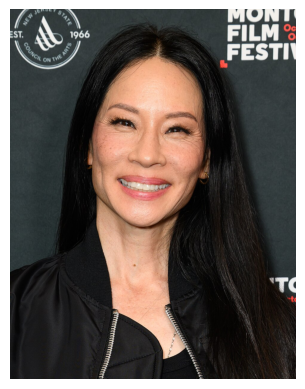

True undertone label: warm
Predicted undertone: warm
ITA: 13.32
Recommended season: Autumn
Style tips: Rich warm tones: olive, mustard, terracotta, camel, antique gold.


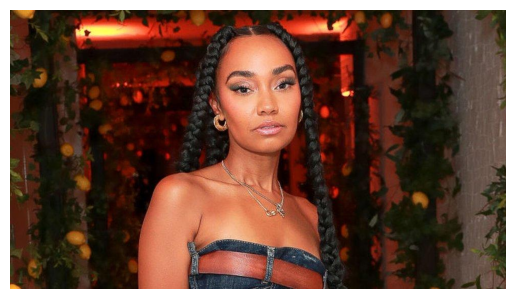

True undertone label: warm
Predicted undertone: warm
ITA: 20.35
Recommended season: Autumn
Style tips: Rich warm tones: olive, mustard, terracotta, camel, antique gold.


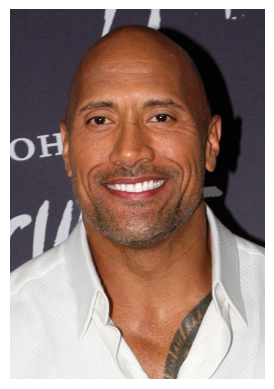

True undertone label: warm
Predicted undertone: warm
ITA: 23.65
Recommended season: Autumn
Style tips: Rich warm tones: olive, mustard, terracotta, camel, antique gold.


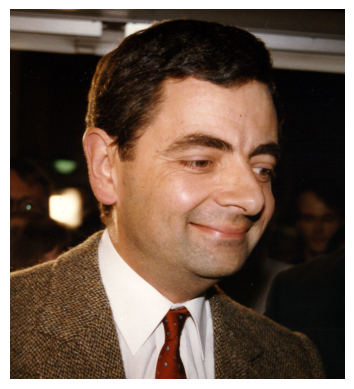

True undertone label: warm
Predicted undertone: warm
ITA: 20.03
Recommended season: Autumn
Style tips: Rich warm tones: olive, mustard, terracotta, camel, antique gold.


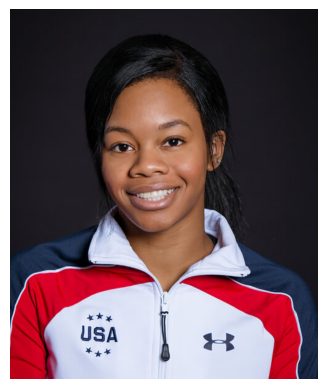

In [79]:
def show_example_with_season(idx):
    row = df.iloc[idx]
    x = row[feature_cols].values.reshape(1, -1)

    true_tone = row["label"]
    pred_tone = best_clf.predict(x)[0]   # tuned model
    ita_val = row["ITA"]

    season = tone_ita_to_season(pred_tone, ita_val)
    tips = SEASON_TIPS.get(season, "No tips available.")

    print("True undertone label:", true_tone)
    print("Predicted undertone:", pred_tone)
    print(f"ITA: {ita_val:.2f}")
    print("Recommended season:", season)
    print("Style tips:", tips)

    img_bgr = cv2.imread(row["path"])
    if img_bgr is None: # Added check to prevent crash if image can't be read
        print(f"Warning: Could not read image at path: {row['path']}")
        return # Skip this iteration

    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis("off")
    plt.show()

# Show a few examples
for i in range(10):
    show_example_with_season(i)